### USA air pollution analysis and forcasting using xgboost

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
open_aq = BigQueryHelper(active_project="bigquery-public-data", dataset_name="epa_historical_air_quality")

In [23]:
open_aq.list_tables()

['air_quality_annual_summary',
 'co_daily_summary',
 'co_hourly_summary',
 'hap_daily_summary',
 'hap_hourly_summary',
 'lead_daily_summary',
 'no2_daily_summary',
 'no2_hourly_summary',
 'nonoxnoy_daily_summary',
 'nonoxnoy_hourly_summary',
 'o3_daily_summary',
 'o3_hourly_summary',
 'pm10_daily_summary',
 'pm10_hourly_summary',
 'pm25_frm_daily_summary',
 'pm25_frm_hourly_summary',
 'pm25_nonfrm_daily_summary',
 'pm25_nonfrm_hourly_summary',
 'pm25_speciation_daily_summary',
 'pm25_speciation_hourly_summary',
 'pressure_daily_summary',
 'pressure_hourly_summary',
 'rh_and_dp_daily_summary',
 'rh_and_dp_hourly_summary',
 'so2_daily_summary',
 'so2_hourly_summary',
 'temperature_daily_summary',
 'temperature_hourly_summary',
 'voc_daily_summary',
 'voc_hourly_summary',
 'wind_daily_summary',
 'wind_hourly_summary']

#### Overview of data in table

In [24]:
open_aq.head("co_hourly_summary")

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,date_local,...,units_of_measure,mdl,uncertainty,qualifier,method_type,method_code,method_name,state_name,county_name,date_of_last_change
0,06,013,3001,42101,1,38.029258,-121.896866,NAD83,Carbon monoxide,1998-06-10,...,Parts per million,0.5,None,None,FRM,54,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,Contra Costa,None
1,06,013,3001,42101,1,38.029258,-121.896866,NAD83,Carbon monoxide,1998-06-11,...,Parts per million,0.5,None,None,FRM,54,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,Contra Costa,None
2,06,013,3001,42101,1,38.029258,-121.896866,NAD83,Carbon monoxide,1998-06-12,...,Parts per million,0.5,None,None,FRM,54,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,Contra Costa,None
3,06,013,3001,42101,1,38.029258,-121.896866,NAD83,Carbon monoxide,1998-06-13,...,Parts per million,0.5,None,None,FRM,54,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,Contra Costa,None
4,06,013,3001,42101,1,38.029258,-121.896866,NAD83,Carbon monoxide,1998-06-14,...,Parts per million,0.5,None,None,FRM,54,INSTRUMENTAL - NONDISPERSIVE INFRARED,California,Contra Costa,None


In [81]:
open_aq.head("co_hourly_summary").columns.values.tolist() # column names

['state_code',
 'county_code',
 'site_num',
 'parameter_code',
 'poc',
 'latitude',
 'longitude',
 'datum',
 'parameter_name',
 'date_local',
 'time_local',
 'date_gmt',
 'time_gmt',
 'sample_measurement',
 'units_of_measure',
 'mdl',
 'uncertainty',
 'qualifier',
 'method_type',
 'method_code',
 'method_name',
 'state_name',
 'county_name',
 'date_of_last_change']

#### Avarage quality of air across counties in the USA in 2015

In [27]:
pollutants = ['o3','co','no2','so2','pm25_frm']

base_query = """
    SELECT
        pollutant.county_name AS County, AVG(pollutant.aqi) AS avg_pollutant
    FROM
      `bigquery-public-data.epa_historical_air_quality.pollutant_daily_summary` as pollutant
    WHERE
      pollutant.poc = 1
      AND EXTRACT(YEAR FROM pollutant.date_local) = 2015
    GROUP BY 
      pollutant.county_name
"""

df = None # reset data frame
for pollutant in pollutants : 
    query = base_query.replace("pollutant", pollutant)
    temp = open_aq.query_to_pandas(query).set_index('County')
    df = pd.concat([df, temp], axis=1, join='outer')
    
df=df.apply(lambda x: x.fillna(x.mean()),axis=0)

df.sample(10,random_state=42)

,avg_o3,avg_co,avg_no2,avg_so2,avg_pm25_frm
Kay,39.630996,4.555269,14.998002,8.550685,32.107462
Pointe Coupee,34.227397,4.555269,14.998002,4.287571,32.107462
Sheboygan,43.576142,4.555269,14.998002,4.287571,32.107462
Atlantic,37.824658,4.555269,14.998002,0.586301,30.004505
Monongalia,43.668224,4.555269,14.998002,3.917808,33.434783
Mitchell,38.645393,4.555269,14.998002,4.287571,29.591667
Blount,38.355109,1.957507,14.998002,4.287571,32.508621
Carroll,44.547739,4.555269,14.998002,4.287571,32.107462
Glenn,39.298630,4.555269,14.998002,4.287571,32.107462
Ottawa,36.958621,4.555269,14.998002,4.823864,32.107462


#### Avarage pollution indicators of air across all years in Callifornia

In [65]:
query_callifornia = """
    SELECT 
        EXTRACT(YEAR FROM date_local) as `Year`,
        AVG(aqi) AS avg_pollutant
    FROM 
        `bigquery-public-data.epa_historical_air_quality.pollutant_daily_summary`
    WHERE 
        state_name  = 'California'
        AND poc = 1
    GROUP BY 
        Year
    ORDER BY
        Year
"""
df = None # reset data frame
for pollutant in pollutants : 
    query = callifornia.replace("pollutant", pollutant)
    temp = open_aq.query_to_pandas(query).set_index('Year')
    df = pd.concat([df, temp], axis=1, join='outer')

In [66]:
df

,avg_o3,avg_co,avg_no2,avg_so2,avg_pm25_frm
Year,,,,,
1990,51.098111,19.861226,31.316124,6.993801,NaN
1991,52.360418,19.441517,31.224138,6.535375,NaN
1992,51.253948,17.619513,28.737330,5.771909,NaN
1993,48.635782,16.360953,28.399565,4.372030,NaN
1994,49.873171,16.259633,28.819707,4.982055,NaN
1995,49.171494,15.108372,28.385343,6.098308,NaN
1996,50.322621,13.837452,27.440994,6.032032,NaN
1997,46.034072,13.224436,26.516726,5.606212,NaN
1998,48.336109,13.167468,26.900859,6.339536,111.550000


### Daily  and Monthly data of CO in Los Angeles

In [135]:
query_co = """
    SELECT
        date_local,
        aqi
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
"""
# state_name  = 'California'
co = open_aq.query_to_pandas(query_co)

In [136]:
co.head()

,date_local,aqi
0,1992-01-21,60.0
1,1997-01-31,42.0
2,2006-09-05,0.0
3,1994-08-25,36.0
4,1993-10-25,45.0


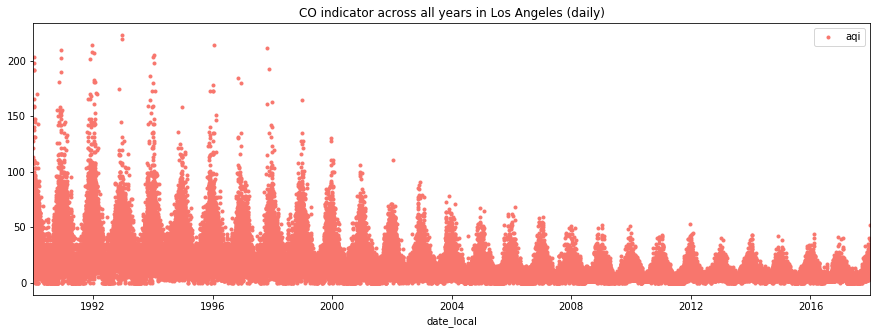

In [156]:
co.set_index('date_local').plot(style='.', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (daily)')

In [140]:
query_co_monthly = """
    SELECT
        FORMAT_DATE("%Y-%m", date_local) as Month,
        AVG(aqi) as avg_aqi
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
    GROUP BY 
        Month
    ORDER BY 
        Month ASC
"""
co_monthly = open_aq.query_to_pandas(query_co_monthly)

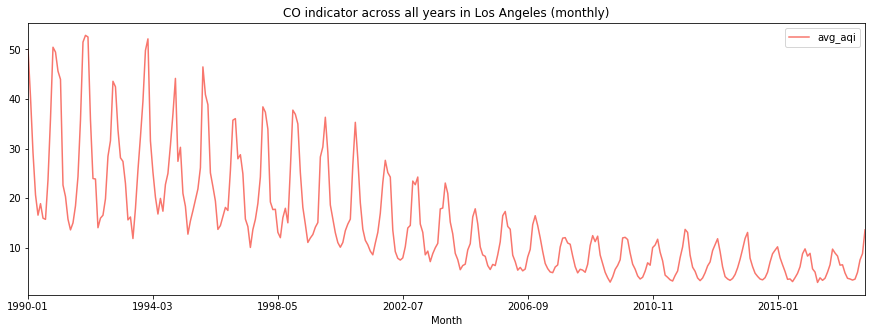

In [155]:
co_monthly.set_index('Month').plot(style='-', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (monthly)')

### By day analysis, but using agragate hourly data

In [142]:
query_co_avg_daily = """
    SELECT
        FORMAT_DATE("%Y-%m-%d", date_local) as Day,
        AVG(sample_measurement) as avg_measurement
    FROM
        `bigquery-public-data.epa_historical_air_quality.co_hourly_summary`
    WHERE
        poc = 1 
        AND county_name = 'Los Angeles'
    GROUP BY 
        Day
    ORDER BY 
        Day ASC
"""
co_avg_daily = open_aq.query_to_pandas(query_co_avg_daily)

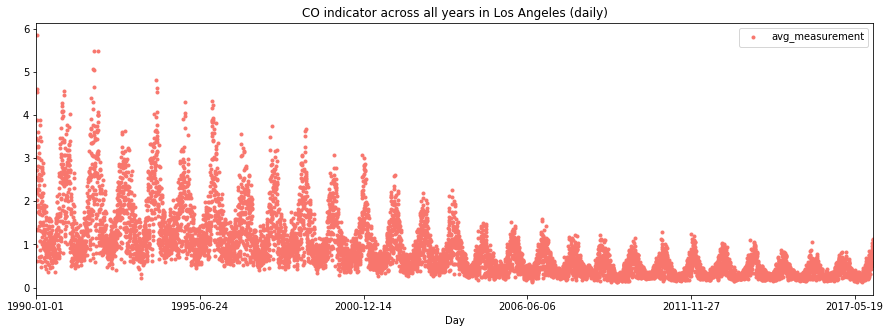

In [154]:
co_avg_daily.set_index('Day').plot(style='.', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (daily)')

### Training, data cleaning, splitting

In [414]:
split_date = '2011-01-01'
co_train = co_avg_daily.loc[co_avg_daily['Day'] <= split_date].copy()
co_test = co_avg_daily.loc[co_avg_daily['Day'] > split_date].copy()

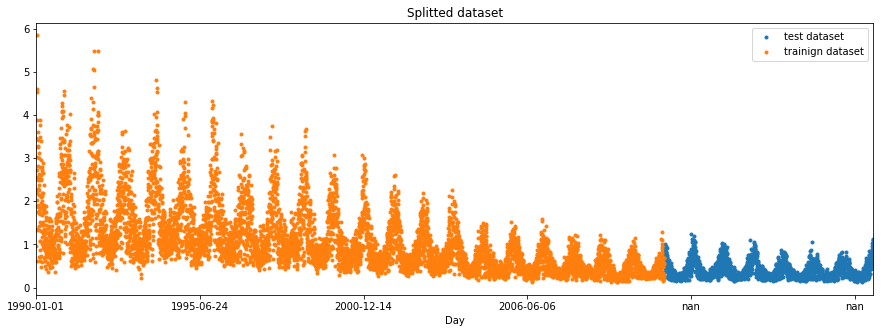

In [415]:
co_test \
    .rename(columns={'avg_measurement': 'test dataset'}) \
    .join(co_train.rename(columns={'avg_measurement': 'trainign dataset'}), how='outer', lsuffix='_left') \
    .set_index('Day') \
    .plot(figsize=(15,5), title='Splitted dataset', style='.')

In [416]:
def create_features_dep(df, x_label='Day', y_label='avg_measurement'):
    df[x_label] = pd.to_datetime(df[x_label])
    
    return df[x_label].as_matrix().reshape((-1,1)), df[y_label].as_matrix()

In [481]:
def create_features(df, x_label='Day', y_label='avg_measurement'):
    df['date'] = pd.to_datetime(df[x_label])
    df['hour'] = df['date'].dt.hour
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofyear','quarter','month','year', 'weekofyear', 'dayofmonth']]
    y = df[y_label]

    return X, y


In [482]:
X_train, y_train = create_features(co_train)
X_test, y_test = create_features(co_test)

In [483]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True) 

[01:49:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.848206	validation_1-rmse:0.213465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.792085	validation_1-rmse:0.2108
[2]	validation_0-rmse:0.742634	validation_1-rmse:0.206968
[3]	validation_0-rmse:0.700011	validation_1-rmse:0.204899
[4]	validation_0-rmse:0.6627	validation_1-rmse:0.202281
[5]	validation_0-rmse:0.630743	validation_1-rmse:0.199591
[6]	validation_0-rmse:0.602566	validation_1-rmse:0.196859
[7]	validation_0-rmse:0.57749	validation_1-rmse:0.195582
[8]	validation_0-rmse:0.555389	validation_1-rmse:0.195502
[9]	validation_0-rmse:0.536868	validation_1-rmse:0.193545
[10]	validation_0-rmse:0.520906	validation_1-rmse:0.191365
[11]	validation_0-rmse:0.507259	validation_

[134]	validation_0-rmse:0.396904	validation_1-rmse:0.138589
[135]	validation_0-rmse:0.396871	validation_1-rmse:0.13858
[136]	validation_0-rmse:0.396586	validation_1-rmse:0.13859
[137]	validation_0-rmse:0.396518	validation_1-rmse:0.138543
[138]	validation_0-rmse:0.396267	validation_1-rmse:0.138524
[139]	validation_0-rmse:0.395881	validation_1-rmse:0.138535
Stopping. Best iteration:
[89]	validation_0-rmse:0.404903	validation_1-rmse:0.137567



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

### Importance of certain features
As we predicted before the most valuable feature are `days`, this feature was most commonly used to split trees, hour and year came in next. 
Quarter has low importance due to the fact that it could be created by different dayofyear splits.

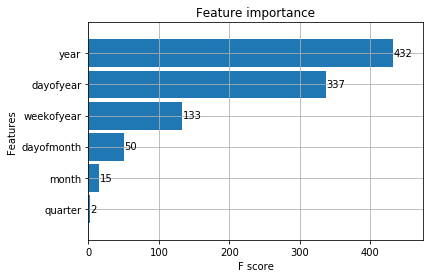

In [484]:
plot_importance(reg, height=0.9)

In [485]:
co_test['co_prediction'] = reg.predict(X_test)
co_all = pd.concat([co_test, co_train], sort=True)

In [486]:
co_all.head()

,Day,abs_error,avg_measurement,co_prediction,date,dayofmonth,dayofyear,error,hour,month,quarter,weekofyear,year
7671,2011-01-02,0.178871,0.356426,0.580091,2011-01-02,2,2,-0.178871,0,1,1,52,2011
7672,2011-01-03,0.312688,0.359434,0.660985,2011-01-03,3,3,-0.312688,0,1,1,1,2011
7673,2011-01-04,0.228420,0.511438,0.742785,2011-01-04,4,4,-0.228420,0,1,1,1,2011
7674,2011-01-05,0.209574,0.530284,0.742785,2011-01-05,5,5,-0.209574,0,1,1,1,2011
7675,2011-01-06,0.123524,0.664423,0.783682,2011-01-06,6,6,-0.123524,0,1,1,1,2011


In [487]:
co_all_pred = co_all[['avg_measurement','co_prediction', 'date']] # easier plotting

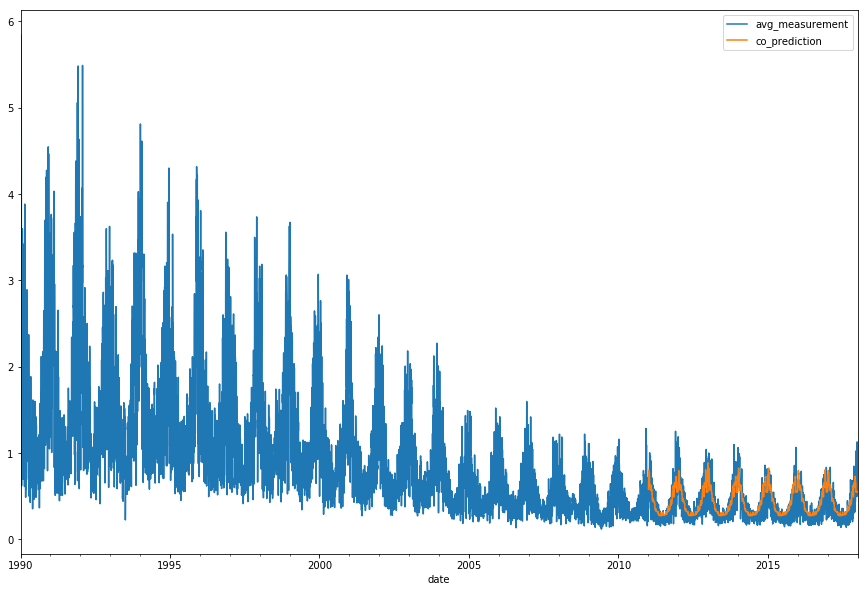

In [488]:
co_all_pred.set_index('date').sort_index().plot(figsize=(15, 10))

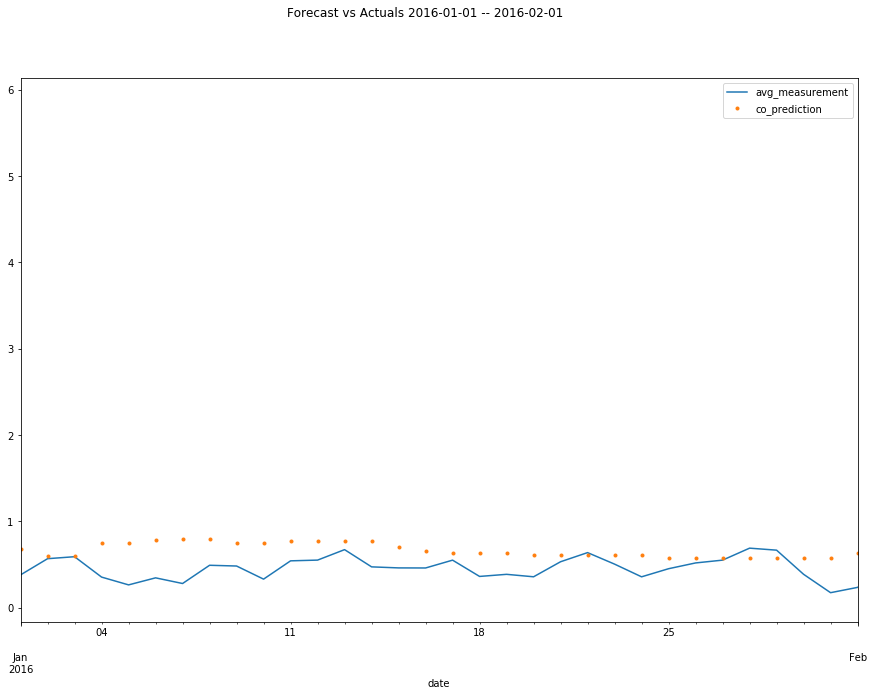

In [489]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)

co_all_pred.set_index('date').sort_index().plot(ax=ax, style=['-','.'])

ax.set_xbound(lower='2016-01-01', upper='2016-02-01')
plot = plt.suptitle('Forecast vs Actuals 2016-01-01 -- 2016-02-01')

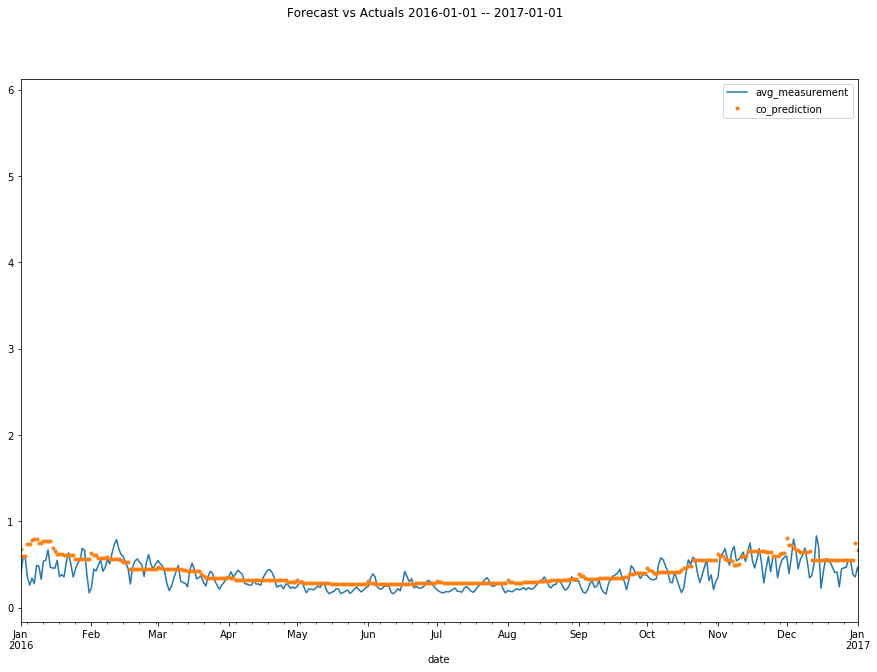

In [490]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)

co_all_pred.set_index('date').sort_index().plot(ax=ax, style=['-','.'])

ax.set_xbound(lower='2016-01-01', upper='2017-01-01')
plot = plt.suptitle('Forecast vs Actuals 2016-01-01 -- 2017-01-01')

#### Worst and best predictions

In [491]:
co_test['error'] = co_test['avg_measurement'] - co_test['co_prediction']
co_test['abs_error'] = co_test['error'].apply(np.abs)

error_by_day = co_test.groupby(['year','month','dayofmonth']).mean()[['avg_measurement','co_prediction','error','abs_error']]

In [498]:
error_by_day.sort_values('abs_error', ascending=False).head(20)

avg_measurement  co_prediction     error  abs_error
year month dayofmonth                                                     
2011 12    31                 1.187975       0.552234  0.635741   0.635741
     11    29                 1.251877       0.627302  0.624575   0.624575
2017 12    26                 1.128794       0.548687  0.580107   0.580107
2011 12    27                 1.095395       0.548687  0.546708   0.546708
           29                 1.093968       0.548687  0.545282   0.545282
2017 12    25                 1.093536       0.548687  0.544849   0.544849
           27                 1.091120       0.548687  0.542433   0.542433
2011 12    30                 1.084026       0.548687  0.535339   0.535339
2016 1     7                  0.278448       0.797956 -0.519507   0.519507
2015 12    9                  1.064794       0.548834  0.515960   0.515960
2017 1     11                 0.256028       0.770585 -0.514556   0.514556
2016 1     5                  0.262500       0.742785 -0.480285   0.480285
2012 12    1                  0.329452       0.807167 -0.477715   0.477715
2011 12    9                  1.124684       0.648188  0.476496   0.476496
2012 12    2                  0.258419       0.729402 -0.470983   0.470983
2017 12    14                 1.025670       0.555791  0.469879   0.469879
2013 11    12                 1.098561       0.633162  0.465399   0.465399
2011 12    1                  0.263987       0.722704 -0.458717   0.458717
2015 11    16                 0.201107       0.652197 -0.451090   0.451090
2017 1     12                 0.320351       0.770585 -0.450234   0.450234

In [ ]:
# DART Booster

# dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
# dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# # specify parameters via map
# param = {'booster': 'dart',
#          'max_depth': 5, 'learning_rate': 0.1,
#          'objective': 'binary:logistic',
#          'sample_type': 'uniform',
#          'normalize_type': 'tree',
#          'rate_drop': 0.1,
#          'skip_drop': 0.5}
# num_round = 50
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# # ntree_limit must not be 0
# preds = bst.predict(dtest, ntree_limit=num_round)